In [1]:
# default_exp multi_armed_bandits

# multi_armed_bandits

> module for generating bandit responses

In [2]:
#hide
from nbdev.showdoc import *

import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
#export
import numpy as np
import scipy.stats as stats



In [4]:
#hide
theta = [0.1, 0.9]

## Categorical Features

### noncontextual

In [5]:
#export
def non_contextual_categorical_customer_reaction(choice:int, theta:np.array)->bool:

    # draw a number between 0 and 1, if it's smaller than the theta, return reward
    if np.random.random() < theta[choice]:
        reaction = True
    else:
        reaction = False

    return reaction

In [6]:
y0 = [non_contextual_categorical_customer_reaction(0,theta) for i in range(100)]
y1 = [non_contextual_categorical_customer_reaction(1,theta) for i in range(100)]


np.mean(y0), np.mean(y1)

(0.06, 0.91)

In [7]:
assert non_contextual_categorical_customer_reaction(1,theta) in [True, False]

## numerical


### contextual

In [8]:
#export
def contextual_numerical_customer_reaction(context:np.array, choice:int, theta:np.array, noise=float)->float:
    features  = np.append(context,choice)

    # decide on which slope to use depending on whether a dog is present or not
    m = theta[0] if features[1] else theta[1]
    intercept = 0 if features[1] else 0

    # $y = x \cdot m + t + \epsilon $
    y = features[0] * m + intercept +  np.random.normal(0,noise)


    return y

In [9]:
contextual_numerical_customer_reaction(np.array([1]),1,theta,0.1)

0.1269160530264946

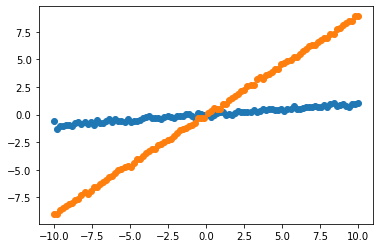

In [10]:
X = np.linspace(-10,10,100)
y0 = [contextual_numerical_customer_reaction(x,0,theta,0.1) for x in X]
y1 = [contextual_numerical_customer_reaction(x,1,theta,0.1) for x in X]

plt.scatter(X,y1)
plt.scatter(X,y0)


In [11]:
np.mean(y1), np.mean(y0)

(0.0002709769794908246, -0.02176973484313855)